# FUFI environment
The environment for our real life Cart-Pole

## Description
A pole is attached by an un-actuated joint to a cart, which moves along a track with friction.
The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

****
                                    Action Space

The action is a `ndarray` with shape `(1,)` which can take values in the interval `{F_max, F_max}` indicating the magnitude of the force the cart is pushed with. Basically we take a discrete action space, in which the minimum corresponds to -F_max - AKA the maximum force our engine can give - and +F_max as the maximum. The steps between one value and the other is the minimum force our engine can produce, let's say 1 for the time being. Sign - and + refers to our sistem of reference.

    | Num  | Action                              |
    |------|-------------------------------------|
    |   0  | Push cart to the left with F=10 N   |
    |   1  | Push cart to the left with F=9.9 N  |
    | ---- | ----------------------------------- |
    |  10  |      Push cart with null force      |
    | ---- | ----------------------------------- |
    |  19  | Push cart to the right with F=9.9 N |
    |  20  | Push cart to the right with F=10 N  |

In RL the action space has to be defined with positive values, so the index of each action has to be mapped into the value of the force.
Given this, doing some math, we get:
*  `Action space length` : 2*F_max/sensibility +1
*  `Action index of null force` : F_max
*  `Force vector`        : -F_max + action_index*sensibility
    
****
                                    Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

    |Num|   Observation  |    Min     |    Max    |
    |---|----------------|------------|-----------|
    | 0 |  Pole a_t      | -F_max/m_p | F_max/m_p |
    | 1 | Pole Theta     | ~ (-24°)   | ~ (24°)   |
    | 2 | Pole Theta dot |    -Inf    |   Inf     |

*Note:* While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. In particular:

-The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates if the cart leaves the `(-2.4, 2.4)` range, that means it hits the end of the track.

-The pole angle can be observed between `(-.418, .418)` radians `(or ±24°)`, but the episode terminates if the pole angle is not in the range `(-.0349, .0349)` `(or ±2°)`.

****
                                    Rewards

Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken,including the termination step, is allotted. The threshold for rewards is raised to 1000.
****
                                  Manner
There are 2 ways implemented in this code:
1. *Real world* : we take the real FUFI and attach it to the Arduino. The states are measured and imported from a `.txt` file.

2. *Ideas world* : simulation mode. The states are computed using the motion equations of the sistem.
****
                                  Starting State

In simulation mode all observations are assigned a uniformly random value in `(-0.05, 0.05)`, in real world mode we take as initial state the inital measures.
****
                                  Episode End

The episode ends if any one of the following occurs:
1. Termination: Pole Angle is greater than ±2°;
2. Termination: Cart Position is greater than ±2.4,that is when the center of the cart reaches the edge of the display;
3. Truncation: Episode length is greater than 1500;
****
                                Arguments
1. `gym.make('Fufi')`

In [2]:
# importing things
import math
from typing import Optional, Union

import numpy as np

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled


Here our class takes the parameter `exp_mode` (string) that basically tells you if you're working with the real or the simulated FUFI.

*   `exp_mode` = r    ---------->     Real FUFI
*   `exp_mode` = s    ---------->     Simulated FUFI

**Note**: the parameter sensibility has to be a usable number so that the action space is symmetrical.

In [3]:
class FUFI(gym.Env[np.ndarray, Union[int, np.ndarray]]):
  metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

  def __init__(self, exp_mode, render_mode: Optional[str] = None):
## ---------------------------------------- FUFI parameters --------------------------------------- ##
## To be changed according to the instrument

    self.gravity = 9.8          # m/s**2
    self.masscart = 1.0         # Kg
    self.masspole = 0.1         # Kg
    self.total_mass = self.masspole + self.masscart
    self.length = 0.5           # m. Actually half the pole's length
    self.polemass_length = self.masspole * self.length
    self.max_force_mag = 10.0    # N. Maximum force the engine can produce
    self.tau = 0.02              # seconds between state updates (integration pace)
    self.kinematics_integrator = "euler"
    self.sensibility = 0.1      # minimum force mag our engine can produce.
                                # Here let's take 0.1
    self.mode = exp_mode        # Way of usage
    assert self.mode == 's' or self.mode == 'r', "Invalid mode. Insert s, for simulation mode; r for real world mode"
    # Angle at which to fail the episode
    self.theta_threshold_radians = 2 * 2 * math.pi / 360
    # Hits the wall
    self.x_threshold = 2.4

    # Angle limit set to 2 * theta_threshold_radians so failing observation
    # is still within bounds.
    high = np.array(
        [
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max,
        ],
        dtype=np.float32,
    )

    action_space_length = (2*self.max_force_mag)/self.sensibility +1
    # check if it's integer or not
    assert (action_space_length%1 == 0), "Action space length is not an integer, please," \
    "dear human make my life easier and choose an integer value for F_max/sensibility "

    self.action_space = spaces.Discrete(int(action_space_length))
    self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    self.render_mode = render_mode

    self.screen_width = 600
    self.screen_height = 400
    self.screen = None
    self.clock = None
    self.isopen = True
    self.state = None
    self.cart_coordinate = None # x, x_dot

    self.steps_beyond_terminated = None

### ---------------------------------------- STEP FUNCTION -------------------------------------------##
  def step(self, action):
    ## Simulated FUFI
    if self.mode == 's':
      # Check if action is in the right form
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."

      #Assign present state and cart coordinate
      a_t, theta, theta_dot = self.state
      x, x_dot = self.cart_coordinate

      costheta = math.cos(theta)
      sintheta = math.sin(theta)

      # Mapping action into force and apply to the cart
      self.force = -self.max_force_mag + action*self.sensibility

      # Getting next state by resolving the sistem analitically
      temp = (
            self.force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
      thetaacc = (self.gravity * sintheta/2 - costheta * temp) / (
            self.length * (4.0/3.0 - self.masspole * costheta**2 / self.total_mass)
        )
      xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
      a_t = xacc * costheta + self.length * thetaacc - self.gravity * sintheta

      if self.kinematics_integrator == "euler":
          x = x + self.tau * x_dot
          x_dot = x_dot + self.tau * xacc
          theta = theta + self.tau * theta_dot
          theta_dot = theta_dot + self.tau * thetaacc
      else:  # semi-implicit euler
          x_dot = x_dot + self.tau * xacc
          x = x + self.tau * x_dot
          theta_dot = theta_dot + self.tau * thetaacc
          theta = theta + self.tau * theta_dot

      # Assign next state
      self.state = (a_t, theta, theta_dot)
      self.cart_coordinate = (x, x_dot)

      # Check termination
      terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

      if not terminated:
          reward = 1.0
      elif self.steps_beyond_terminated is None:
          # Pole just fell!
          self.steps_beyond_terminated = 0
          reward = 1.0
      else:
          if self.steps_beyond_terminated == 0:
              logger.warn(
                  "You are calling 'step()' even though this "
                  "environment has already returned terminated = True. You "
                  "should always call 'reset()' once you receive 'terminated = "
                  "True' -- any further steps are undefined behavior."
              )
          self.steps_beyond_terminated += 1
          reward = 0.0

      if self.render_mode == "human":
          self.render()

      return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    else:
      print('Real world cartpole non implemented yet')


### -------------------------------------- RESET FUNCTION ------------------------------------------##
# Initialize state as described above
  def reset(
      self,
      *,
      seed: Optional[int] = None,
      options: Optional[dict] = None,
  ):
      super().reset(seed=seed)
      # Note that if you use custom reset bounds, it may lead to out-of-bound
      # state/observations.
      low, high = utils.maybe_parse_reset_bounds(
          options, -0.05, 0.05  # default low
      )  # default high
      self.state = self.np_random.uniform(low=low, high=high, size=(3,))
      self.cart_coordinate = self.np_random.uniform(low=low, high=high, size=(2,))
      self.steps_beyond_terminated = None

      if self.render_mode == "human":
          self.render()
      return np.array(self.state, dtype=np.float32), {}

### -------------------------------- RENDER FUNCTION ------------------------------------- ##
# Display the environment
  def render(self):
      if self.render_mode is None:
          gym.logger.warn(
              "You are calling render method without specifying any render mode. "
              "You can specify the render_mode at initialization, "
              f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
          )
          return

      try:
          import pygame
          from pygame import gfxdraw
      except ImportError:
          raise DependencyNotInstalled(
              "pygame is not installed, run `pip install gym[classic_control]`"
          )

      if self.screen is None:
          pygame.init()
          if self.render_mode == "human":
              pygame.display.init()
              self.screen = pygame.display.set_mode(
                  (self.screen_width, self.screen_height)
              )
          else:  # mode == "rgb_array"
              self.screen = pygame.Surface((self.screen_width, self.screen_height))
      if self.clock is None:
          self.clock = pygame.time.Clock()

      world_width = self.x_threshold * 2
      scale = self.screen_width / world_width
      polewidth = 10.0
      polelen = scale * (2 * self.length)
      cartwidth = 50.0
      cartheight = 30.0

      if self.state is None:
          return None

      x = self.state

      self.surf = pygame.Surface((self.screen_width, self.screen_height))
      self.surf.fill((255, 255, 255))

      l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
      axleoffset = cartheight / 4.0
      cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
      carty = 100  # TOP OF CART
      cart_coords = [(l, b), (l, t), (r, t), (r, b)]
      cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
      gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
      gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

      l, r, t, b = (
          -polewidth / 2,
          polewidth / 2,
          polelen - polewidth / 2,
          -polewidth / 2,
      )

      pole_coords = []
      for coord in [(l, b), (l, t), (r, t), (r, b)]:
          coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
          coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
          pole_coords.append(coord)
      gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
      gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

      gfxdraw.aacircle(
          self.surf,
          int(cartx),
          int(carty + axleoffset),
          int(polewidth / 2),
          (129, 132, 203),
      )
      gfxdraw.filled_circle(
          self.surf,
          int(cartx),
          int(carty + axleoffset),
          int(polewidth / 2),
          (129, 132, 203),
      )

      gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

      self.surf = pygame.transform.flip(self.surf, False, True)
      self.screen.blit(self.surf, (0, 0))
      if self.render_mode == "human":
          pygame.event.pump()
          self.clock.tick(self.metadata["render_fps"])
          pygame.display.flip()

      elif self.render_mode == "rgb_array":
          return np.transpose(
              np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
          )
## ------------------------------------- CLOSE FUNCTION --------------------------------------##
# Close the rendering
  def close(self):
      if self.screen is not None:
          import pygame

          pygame.display.quit()
          pygame.quit()
          self.isopen = False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


Found GPU at: /device:GPU:0


(array([ 0.03318927, -0.02128921,  0.04620332], dtype=float32), {})

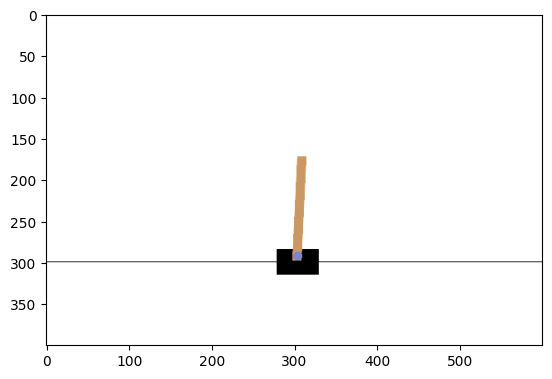

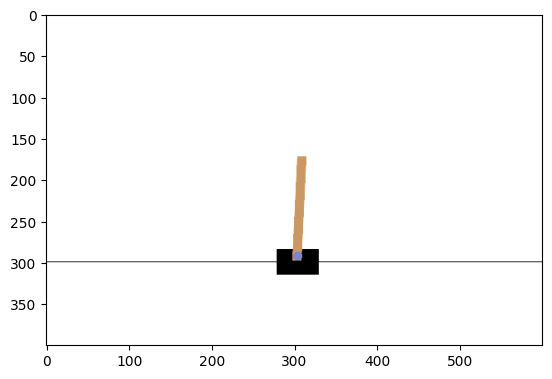

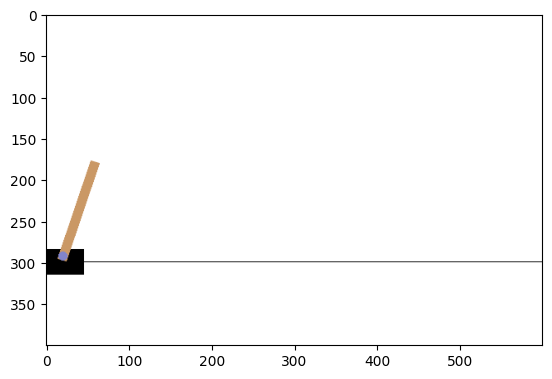

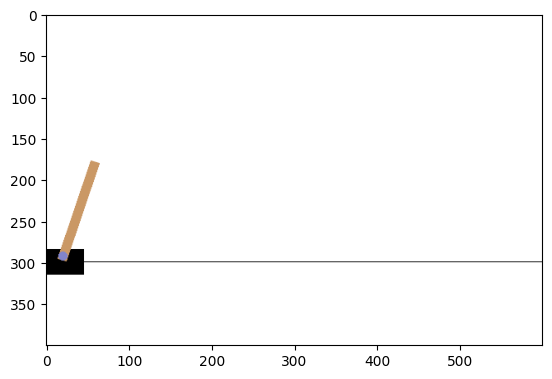